# Libs

In [1]:
import os
import time
import glob
import json
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Reshape, Activation, Dropout, Flatten
from tensorflow.keras.layers import Embedding, Concatenate, Add, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, normalize

from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

import lightgbm as lgb

from utils import *

# Load Data

In [45]:
X = pd.read_csv('../Data/X.csv')
Y = pd.read_csv('../Data/Y.csv')

# load feature type columns
with open('../Data/feature_types.json', 'r') as f:
    categorical_features, numeric_features = json.load(f)

# one-hot encoding cat features
X_onehot = one_hot_encoding(X, categorical_features)

# split the dataset
use_features = ['volume', 'through', 'left', 'right', 'thr_left',
                'thr_right', 'u_turn', 'num_lanes',
                'weekday', 'interval', 'holiday', 'peak',
                'volume', 'volume_es_p6', 'volume_es_p5']
X_train, X_test, y_train, y_test = dataset_split(X, Y,
                                                 split_mode='fix_transfer',
                                                 use_features=use_features,
                                                 use_best_features=False,
                                                 num_features=None)
current_cat_feats = list(set(X_train.columns).intersection(set(categorical_features)))

# Weight Samples

## KDE

In [49]:
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
kde = kde.fit(X_test.values)
kde_weights = kde.score_samples(X_train.values)

## Logistic

In [50]:
X_data = np.concatenate((X_train.values, X_test.values),axis=0)
y_data = np.concatenate((np.zeros((X_train.shape[0],1)), np.ones((X_test.shape[0],1))),axis=0)

In [51]:
lr = LogisticRegression(penalty='l2',n_jobs=-1)
lr = lr.fit(X_data, y_data)
print("[Logistic] fit score: {:.3f}".format(lr.score(X_data, y_data)))
logit_weight = lr.predict_proba(X_train.values)[:,1]

[Logistic] fit score: 0.836


## LGB

In [52]:
X_data = pd.concat((X_train, X_test),axis=0)
y_data = np.concatenate((np.zeros((X_train.shape[0],1)), np.ones((X_test.shape[0],1))),axis=0)

In [53]:
params = {
    'objective':'binary',
    'boosting':'gbdt',
    'num_rounds':1000,
    'learning_rate':0.01,
    'max_depth':5,
    'num_leaves':20,
    'bagging_fraction':0.5,
    'bagging_freq':100,
    'verbose':2
}

train_data = lgb.Dataset(X_data, y_data.reshape(-1),
                         categorical_feature=current_cat_feats)
gbm = lgb.train(params, train_data)

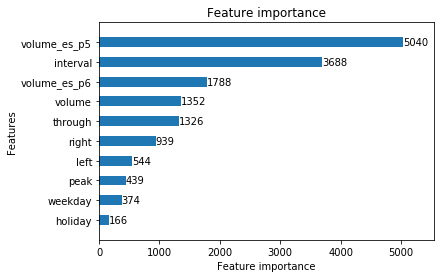

In [54]:
lgb.plot_importance(gbm, max_num_features=10,grid=False,height=0.5)

In [55]:
gbm_weights = gbm.predict(X_data)[:X_train.shape[0]]

## MLP

In [56]:
def build_mlp_clf(input_shape):
    x_in = Input(shape=(input_shape,))

    def dense_block(h, units):
        h = Dense(units=units, use_bias=True,
                  activation=None,
                  kernel_initializer=he_normal(),
                  bias_initializer=constant(0.0))(h)
        h = BatchNormalization()(h)
        h = LeakyReLU(0.2)(h)
        h = Dropout(rate=0.5)(h)
        return h

    h = dense_block(x_in, units=32)
    h = dense_block(h, units=16)
    h = Dense(units=1, use_bias=False,
              activation='sigmoid',
              kernel_initializer='normal',
              bias_initializer=constant(0.0))(h)

    mlp_clf = Model(inputs=x_in, outputs=h)
    mlp_clf.compile(loss='binary_crossentropy', optimizer=Adam(3e-4), metrics=['accuracy'])

    return mlp_clf

In [57]:
mlp_clf = build_mlp_clf(input_shape=X_data.shape[1])
hist = mlp_clf.fit(X_data, y_data, batch_size=256, epochs=10, shuffle=True)

Epoch 1/10
103680/103680 [==============================] - 1s 13us/sample - loss: 0.6322 - acc: 0.6534
Epoch 2/10
103680/103680 [==============================] - 1s 9us/sample - loss: 0.5481 - acc: 0.7311
Epoch 3/10
103680/103680 [==============================] - 1s 10us/sample - loss: 0.4947 - acc: 0.7458
Epoch 4/10
103680/103680 [==============================] - 1s 9us/sample - loss: 0.4616 - acc: 0.7517
Epoch 5/10
103680/103680 [==============================] - 1s 10us/sample - loss: 0.4366 - acc: 0.7616
Epoch 6/10
103680/103680 [==============================] - 1s 9us/sample - loss: 0.4148 - acc: 0.7750
Epoch 7/10
103680/103680 [==============================] - 1s 9us/sample - loss: 0.4004 - acc: 0.7817
Epoch 8/10
103680/103680 [==============================] - 1s 10us/sample - loss: 0.3845 - acc: 0.7891
Epoch 9/10
103680/103680 [==============================] - 1s 9us/sample - loss: 0.3727 - acc: 0.7983
Epoch 10/10
103680/103680 [==============================] - 1s 9us/s

In [58]:
mlp_weights = mlp_clf.predict(X_train.values)

# Train Regressor

In [59]:
trunc_kde_weights = -1 / kde_weights

In [60]:
train_data = lgb.Dataset(X_train, y_train,
                         categorical_feature=current_cat_feats)
train_data.set_weight(trunc_kde_weights)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

params = {
    'objective':'regression',
    'boosting':'gbdt',
    'metric':'mae',
    'num_rounds':2000,
    'learning_rate':0.01,
    'max_depth':8,
    'num_leaves':100,
    'feature_fraction':0.6,
    'bagging_fraction':0.6,
    'extra_trees':True,
    'bagging_freq':500,
    'verbose':2
}

gbm = lgb.train(params, train_data,valid_sets=[test_data])

[1]	valid_0's l1: 60.375
[2]	valid_0's l1: 60.2469
[3]	valid_0's l1: 60.134
[4]	valid_0's l1: 60.0184
[5]	valid_0's l1: 59.9579
[6]	valid_0's l1: 59.9678
[7]	valid_0's l1: 59.8663
[8]	valid_0's l1: 59.7577
[9]	valid_0's l1: 59.8692
[10]	valid_0's l1: 59.8817
[11]	valid_0's l1: 59.7743
[12]	valid_0's l1: 59.6839
[13]	valid_0's l1: 59.8145
[14]	valid_0's l1: 59.6559
[15]	valid_0's l1: 59.5688
[16]	valid_0's l1: 59.4163
[17]	valid_0's l1: 59.4417
[18]	valid_0's l1: 59.4718
[19]	valid_0's l1: 59.3773
[20]	valid_0's l1: 59.5061
[21]	valid_0's l1: 59.5315
[22]	valid_0's l1: 59.4454
[23]	valid_0's l1: 59.3641
[24]	valid_0's l1: 59.3949
[25]	valid_0's l1: 59.2801
[26]	valid_0's l1: 59.3081
[27]	valid_0's l1: 59.2139
[28]	valid_0's l1: 59.1338
[29]	valid_0's l1: 59.2489
[30]	valid_0's l1: 59.1905
[31]	valid_0's l1: 59.3037
[32]	valid_0's l1: 59.3252
[33]	valid_0's l1: 59.3126
[34]	valid_0's l1: 59.234
[35]	valid_0's l1: 59.3492
[36]	valid_0's l1: 59.377
[37]	valid_0's l1: 59.3945
[38]	valid_0's

[312]	valid_0's l1: 60.1481
[313]	valid_0's l1: 60.1575
[314]	valid_0's l1: 60.1614
[315]	valid_0's l1: 60.158
[316]	valid_0's l1: 60.1631
[317]	valid_0's l1: 60.1686
[318]	valid_0's l1: 60.1637
[319]	valid_0's l1: 60.1608
[320]	valid_0's l1: 60.1759
[321]	valid_0's l1: 60.1839
[322]	valid_0's l1: 60.1811
[323]	valid_0's l1: 60.1792
[324]	valid_0's l1: 60.1755
[325]	valid_0's l1: 60.1936
[326]	valid_0's l1: 60.2116
[327]	valid_0's l1: 60.2065
[328]	valid_0's l1: 60.2043
[329]	valid_0's l1: 60.2102
[330]	valid_0's l1: 60.2073
[331]	valid_0's l1: 60.2131
[332]	valid_0's l1: 60.2185
[333]	valid_0's l1: 60.2243
[334]	valid_0's l1: 60.2194
[335]	valid_0's l1: 60.2154
[336]	valid_0's l1: 60.2067
[337]	valid_0's l1: 60.2038
[338]	valid_0's l1: 60.2095
[339]	valid_0's l1: 60.2019
[340]	valid_0's l1: 60.2074
[341]	valid_0's l1: 60.2143
[342]	valid_0's l1: 60.2165
[343]	valid_0's l1: 60.2125
[344]	valid_0's l1: 60.2178
[345]	valid_0's l1: 60.2341
[346]	valid_0's l1: 60.2339
[347]	valid_0's l1: 6

[623]	valid_0's l1: 60.556
[624]	valid_0's l1: 60.5574
[625]	valid_0's l1: 60.5553
[626]	valid_0's l1: 60.5543
[627]	valid_0's l1: 60.5547
[628]	valid_0's l1: 60.5606
[629]	valid_0's l1: 60.5604
[630]	valid_0's l1: 60.5599
[631]	valid_0's l1: 60.5649
[632]	valid_0's l1: 60.5675
[633]	valid_0's l1: 60.5681
[634]	valid_0's l1: 60.5691
[635]	valid_0's l1: 60.5692
[636]	valid_0's l1: 60.5685
[637]	valid_0's l1: 60.5683
[638]	valid_0's l1: 60.5669
[639]	valid_0's l1: 60.5698
[640]	valid_0's l1: 60.5714
[641]	valid_0's l1: 60.5742
[642]	valid_0's l1: 60.5748
[643]	valid_0's l1: 60.574
[644]	valid_0's l1: 60.5741
[645]	valid_0's l1: 60.5743
[646]	valid_0's l1: 60.5753
[647]	valid_0's l1: 60.5752
[648]	valid_0's l1: 60.575
[649]	valid_0's l1: 60.5767
[650]	valid_0's l1: 60.577
[651]	valid_0's l1: 60.5779
[652]	valid_0's l1: 60.5798
[653]	valid_0's l1: 60.5826
[654]	valid_0's l1: 60.5873
[655]	valid_0's l1: 60.5891
[656]	valid_0's l1: 60.5893
[657]	valid_0's l1: 60.5899
[658]	valid_0's l1: 60.5

[935]	valid_0's l1: 60.7642
[936]	valid_0's l1: 60.7643
[937]	valid_0's l1: 60.7634
[938]	valid_0's l1: 60.7647
[939]	valid_0's l1: 60.7657
[940]	valid_0's l1: 60.7638
[941]	valid_0's l1: 60.7645
[942]	valid_0's l1: 60.7666
[943]	valid_0's l1: 60.7657
[944]	valid_0's l1: 60.7655
[945]	valid_0's l1: 60.7651
[946]	valid_0's l1: 60.7665
[947]	valid_0's l1: 60.7663
[948]	valid_0's l1: 60.766
[949]	valid_0's l1: 60.7654
[950]	valid_0's l1: 60.7658
[951]	valid_0's l1: 60.7666
[952]	valid_0's l1: 60.767
[953]	valid_0's l1: 60.7669
[954]	valid_0's l1: 60.7673
[955]	valid_0's l1: 60.7673
[956]	valid_0's l1: 60.7693
[957]	valid_0's l1: 60.7701
[958]	valid_0's l1: 60.7712
[959]	valid_0's l1: 60.7714
[960]	valid_0's l1: 60.773
[961]	valid_0's l1: 60.7731
[962]	valid_0's l1: 60.7756
[963]	valid_0's l1: 60.7777
[964]	valid_0's l1: 60.7775
[965]	valid_0's l1: 60.779
[966]	valid_0's l1: 60.7806
[967]	valid_0's l1: 60.7814
[968]	valid_0's l1: 60.783
[969]	valid_0's l1: 60.7831
[970]	valid_0's l1: 60.78

[1228]	valid_0's l1: 60.7968
[1229]	valid_0's l1: 60.7971
[1230]	valid_0's l1: 60.799
[1231]	valid_0's l1: 60.7998
[1232]	valid_0's l1: 60.8009
[1233]	valid_0's l1: 60.8008
[1234]	valid_0's l1: 60.7999
[1235]	valid_0's l1: 60.7994
[1236]	valid_0's l1: 60.8002
[1237]	valid_0's l1: 60.8001
[1238]	valid_0's l1: 60.8003
[1239]	valid_0's l1: 60.8013
[1240]	valid_0's l1: 60.8013
[1241]	valid_0's l1: 60.8016
[1242]	valid_0's l1: 60.8018
[1243]	valid_0's l1: 60.8024
[1244]	valid_0's l1: 60.8035
[1245]	valid_0's l1: 60.8053
[1246]	valid_0's l1: 60.8066
[1247]	valid_0's l1: 60.8074
[1248]	valid_0's l1: 60.8073
[1249]	valid_0's l1: 60.806
[1250]	valid_0's l1: 60.8062
[1251]	valid_0's l1: 60.8055
[1252]	valid_0's l1: 60.8061
[1253]	valid_0's l1: 60.8068
[1254]	valid_0's l1: 60.8076
[1255]	valid_0's l1: 60.806
[1256]	valid_0's l1: 60.8067
[1257]	valid_0's l1: 60.8067
[1258]	valid_0's l1: 60.808
[1259]	valid_0's l1: 60.8077
[1260]	valid_0's l1: 60.8077
[1261]	valid_0's l1: 60.8084
[1262]	valid_0's l

[1513]	valid_0's l1: 60.8664
[1514]	valid_0's l1: 60.8662
[1515]	valid_0's l1: 60.8691
[1516]	valid_0's l1: 60.8694
[1517]	valid_0's l1: 60.8698
[1518]	valid_0's l1: 60.871
[1519]	valid_0's l1: 60.8704
[1520]	valid_0's l1: 60.8705
[1521]	valid_0's l1: 60.8707
[1522]	valid_0's l1: 60.8706
[1523]	valid_0's l1: 60.8706
[1524]	valid_0's l1: 60.871
[1525]	valid_0's l1: 60.8719
[1526]	valid_0's l1: 60.8721
[1527]	valid_0's l1: 60.8715
[1528]	valid_0's l1: 60.8714
[1529]	valid_0's l1: 60.8721
[1530]	valid_0's l1: 60.8711
[1531]	valid_0's l1: 60.8735
[1532]	valid_0's l1: 60.8735
[1533]	valid_0's l1: 60.8742
[1534]	valid_0's l1: 60.876
[1535]	valid_0's l1: 60.8763
[1536]	valid_0's l1: 60.8793
[1537]	valid_0's l1: 60.8785
[1538]	valid_0's l1: 60.8777
[1539]	valid_0's l1: 60.8781
[1540]	valid_0's l1: 60.8788
[1541]	valid_0's l1: 60.8791
[1542]	valid_0's l1: 60.8801
[1543]	valid_0's l1: 60.8793
[1544]	valid_0's l1: 60.8788
[1545]	valid_0's l1: 60.8789
[1546]	valid_0's l1: 60.8792
[1547]	valid_0's 

[1805]	valid_0's l1: 60.9322
[1806]	valid_0's l1: 60.9313
[1807]	valid_0's l1: 60.9321
[1808]	valid_0's l1: 60.9325
[1809]	valid_0's l1: 60.933
[1810]	valid_0's l1: 60.9329
[1811]	valid_0's l1: 60.9328
[1812]	valid_0's l1: 60.9326
[1813]	valid_0's l1: 60.9328
[1814]	valid_0's l1: 60.9328
[1815]	valid_0's l1: 60.9325
[1816]	valid_0's l1: 60.9329
[1817]	valid_0's l1: 60.9327
[1818]	valid_0's l1: 60.932
[1819]	valid_0's l1: 60.9322
[1820]	valid_0's l1: 60.9325
[1821]	valid_0's l1: 60.9327
[1822]	valid_0's l1: 60.9327
[1823]	valid_0's l1: 60.9339
[1824]	valid_0's l1: 60.9335
[1825]	valid_0's l1: 60.9326
[1826]	valid_0's l1: 60.9327
[1827]	valid_0's l1: 60.9336
[1828]	valid_0's l1: 60.9336
[1829]	valid_0's l1: 60.9343
[1830]	valid_0's l1: 60.9329
[1831]	valid_0's l1: 60.933
[1832]	valid_0's l1: 60.9321
[1833]	valid_0's l1: 60.9326
[1834]	valid_0's l1: 60.934
[1835]	valid_0's l1: 60.9338
[1836]	valid_0's l1: 60.9336
[1837]	valid_0's l1: 60.934
[1838]	valid_0's l1: 60.9342
[1839]	valid_0's l1

In [61]:
y_pred = gbm.predict(X_train)

print("[LightGBM] mae: {:.2f} | mape: {:.2f}% | mspe: {:.2f}%".format(
    mae(y_pred, y_train),
    100 * mape(y_pred,y_train), 100 * mspe(y_pred, y_train)))

y_pred = gbm.predict(X_test)

print("[LightGBM] mae: {:.2f} | mape: {:.2f}% | mspe: {:.2f}%".format(
    mae(y_pred, y_test),
    100 * mape(y_pred,y_test), 100 * mspe(y_pred, y_test)))

[LightGBM] mae: 32.19 | mape: 31.59% | mspe: 11.69%
[LightGBM] mae: 60.80 | mape: 62.32% | mspe: 40.61%


(0, 420)

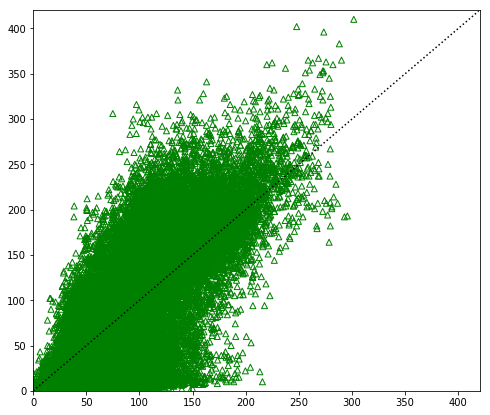

In [48]:
plt.figure(figsize=(8,7))
plt.scatter(y_pred,y_test,marker='^',c='',edgecolors='g')
plt.plot(np.arange(420),np.arange(420),'k:')
plt.xlim([0,420])
plt.ylim([0,420])